In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

SIZE = 256

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(img_name, 1)  # Change 0 to 1 for color images
        image = cv2.resize(image, (SIZE, SIZE))
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Load images
image_dir = '/data1/sprasad/data/unlabeled'
dataset = ImageDataset(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

img_data = []
for img in tqdm(dataloader):
    img_data.append(img.numpy())

img_array = np.concatenate(img_data, axis=0)
img_array = img_array.astype('float32') / 255.
img_array=torch.tensor(img_array).float()

# In the interest of time let us train on 500 images
img_array2 = torch.tensor(img_array[200:700]).float()

/home/sprasad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 4488/4488 [02:01<00:00, 36.81it/s]


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels, out_channels)
        
    def forward(self, x):
        x = self.upconv(x)
        x = self.conv(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels):
        super(Encoder, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        self.bridge = ConvBlock(512, 1024)
        
    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)
        b = self.bridge(p4)
        return s1, s2, s3, s4, b

class AutoencoderDecoder(nn.Module):
    def __init__(self, out_channels):
        super(AutoencoderDecoder, self).__init__()
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)
        self.output = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = torch.sigmoid(self.output(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = AutoencoderDecoder(out_channels)
        
    def forward(self, x):
        _, _, _, _, encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [3]:
import torch.optim as optim

# Hyperparameters
epochs = 800
learning_rate = 1e-3

# Initialize the autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = Autoencoder(in_channels=3, out_channels=3).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


In [4]:

# Training loop
autoencoder.train()
for epoch in range(epochs):
    epoch_loss = 0
    for img in tqdm(img_array):
        img = img.to(device)
        optimizer.zero_grad()
        output = autoencoder(img.unsqueeze(0))
        loss = criterion(output, img.unsqueeze(0))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(img_array)}')
    torch.save(autoencoder.state_dict(),f'auto_encoder_wts/pretrained_wt_unet_model_epoch_{epoch+1}.pth')
    
# Save the model



/tmp/ipykernel_3234236/2206881312.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_img_tensor = torch.tensor(test_img).float().unsqueeze(0).to(device)


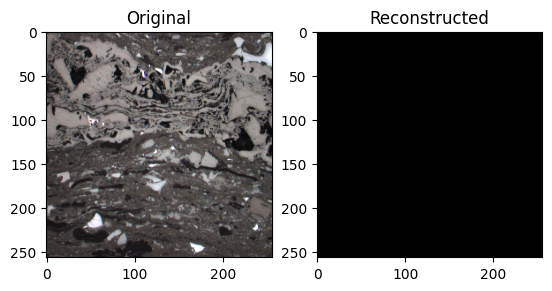

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load the model
autoencoder.load_state_dict(torch.load('auto_encoder_wts/pretrained_wt_unet_model_epoch_304.pth'))
autoencoder.eval()

# Test on a few images
num = np.random.randint(0, len(img_array))
test_img = img_array[num]
test_img_tensor = torch.tensor(test_img).float().unsqueeze(0).to(device)

with torch.no_grad():
    pred = autoencoder(test_img_tensor)

# Plot the original and reconstructed images
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(test_img, (1, 2, 0)) * 255)  # Corrected transpose for numpy array
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(pred.cpu().numpy()[0], (1, 2, 0)))  # Corrected transpose for numpy array
plt.title('Reconstructed')
plt.show()


In [6]:
class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
        
    def forward(self, x, skip_connection):
        x = self.upconv(x)
        x = torch.cat((x, skip_connection), dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = Encoder(in_channels)
        self.dec1 = UNetDecoderBlock(1024, 512)
        self.dec2 = UNetDecoderBlock(512, 256)
        self.dec3 = UNetDecoderBlock(256, 128)
        self.dec4 = UNetDecoderBlock(128, 64)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        s1, s2, s3, s4, b = self.encoder(x)
        x = self.dec1(b, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)
        x = torch.sigmoid(self.output(x))
        return x

# Initialize U-Net model
unet_model = UNet(in_channels=3, out_channels=3).to(device)


In [7]:
# Initialize U-Net model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = UNet(in_channels=3, out_channels=3).to(device)

# Load weights from autoencoder to U-Net
autoencoder = Autoencoder(in_channels=3, out_channels=3).to(device)

In [8]:
autoencoder.load_state_dict(torch.load('weights/autoencoder_500imgs_1epochs.pth'))
autoencoder_weights = autoencoder.state_dict()

In [9]:
unet_encoder_dict = unet_model.encoder.state_dict()

In [10]:
autoencoder_encoder_dict = {k: v for k, v in autoencoder_weights.items() if k in unet_encoder_dict}


In [11]:
unet_encoder_dict.update(autoencoder_encoder_dict)

In [12]:
unet_model.encoder.load_state_dict(unet_encoder_dict)


<All keys matched successfully>

In [13]:
torch.save(unet_model.state_dict(), 'unet_model_weights.pth')